# Data Load

https://www.kaggle.com/datasets/adityajn105/flickr8k

# Dataset

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

In [32]:
import time
from glob import glob
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision
from collections import namedtuple

In [3]:
from PIL import Image
import torchvision.transforms as transforms
from torchvision import models

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [18]:
data_dir = '../PycharmProjects/real_styler/data/Images/'

In [19]:
class FlickrDataset(Dataset):
    def __init__(self, root: str, transform):

        self.filenames = glob(f"{root}/*.jpg")
        self.transform = transform
        
    def __getitem__(self, index):
        image = Image.open(self.filenames[index])
        return self.transform(image)
    
    def __len__(self):
        return len(self.filenames)

In [20]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ColorJitter(brightness=(0.6, 1.3), contrast=(0.6, 1.4)),
    transforms.RandomRotation((-10, 10)), 
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255)),
])

style_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.mul(255)),
])

In [21]:
train_dataset = FlickrDataset(data_dir, transform)

In [22]:
batch_size=12

In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)

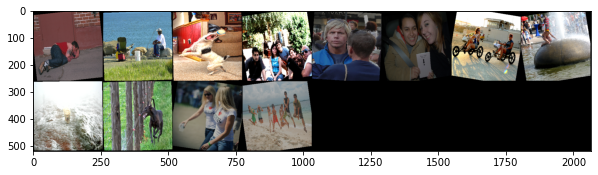

In [26]:
def myshow(img):
    npimg = img.detach().numpy()
    fig = plt.figure(figsize=(10, 10))
    plt.imshow(npimg.transpose(1, 2, 0).astype("uint8"))

trainiter = iter(train_loader)
images = next(trainiter)
myshow(torchvision.utils.make_grid(images))

# Model

In [27]:
class ConvBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                ):
        super(ConvBlock, self).__init__()
        to_pad = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(to_pad)
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        
    def forward(self, x):
        return self.conv(self.reflection_pad(x))

In [28]:
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            ConvBlock(in_channels=channels, out_channels=channels, kernel_size=3, stride=1),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU(),
            ConvBlock(in_channels=channels, out_channels=channels, kernel_size=3, stride=1),
            nn.InstanceNorm2d(channels, affine=True),
            nn.ReLU()
        )
        
    def forward(self, x):
        return x + self.block(x)

In [29]:
class UpsampleBlock(nn.Module):
    def __init__(self,
                 in_channels: int,
                 out_channels: int,
                 kernel_size: int,
                 stride: int,
                 scale: int
                ):
        super(UpsampleBlock, self).__init__()
        to_pad = kernel_size // 2
        self.reflection_pad = nn.ReflectionPad2d(to_pad)
        self.upsample = nn.Upsample(scale_factor=scale, mode='nearest')
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride)
        
    def forward(self, x):
        return self.conv(self.reflection_pad(self.upsample(x)))

In [30]:
class TransformNet(nn.Module):
    def __init__(self):
        super(TransformNet, self).__init__()
        
        self.encoder = nn.Sequential(
            ConvBlock(in_channels=3, out_channels=32, kernel_size=9, stride=1),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(),
            ConvBlock(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
            ConvBlock(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.InstanceNorm2d(128, affine=True),
            nn.ReLU(),
        )
        
        self.residual = nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
        )
        
        self.decoder = nn.Sequential(
            UpsampleBlock(in_channels=128, out_channels=64, kernel_size=3, stride=1, scale=2),
            nn.InstanceNorm2d(64, affine=True),
            nn.ReLU(),
            UpsampleBlock(in_channels=64, out_channels=32, kernel_size=3, stride=1, scale=2),
            nn.InstanceNorm2d(32, affine=True),
            nn.ReLU(),
            ConvBlock(in_channels=32, out_channels=3, kernel_size=9, stride=1),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        residual = self.residual(encoded)
        decoded = self.decoder(residual)
        return decoded

In [31]:
class VGG16Loss(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super(VGG16Loss, self).__init__()

        vgg_pretrained_features = models.vgg16(pretrained=True).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])

        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, x):
        h = self.slice1(x)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3)
        return out

In [33]:
def normalize_for_vgg(batch):
    mean = batch.new_tensor([0.485, 0.456, 0.406]).view(-1, 1, 1)
    std = batch.new_tensor([0.229, 0.224, 0.225]).view(-1, 1, 1)
    batch = batch.div(255.0)
    return (batch - mean) / std

In [34]:
def gram_matrix_batch(batch):
    batch_size, channels, height, width = batch.shape
    features = batch.view(batch_size, channels, height * width)
    return features.bmm(features.transpose(1, 2)) / (channels * height * width)

In [36]:
num_epochs = 12

#основная сеть и оптимайзер
transformer = TransformNet().to(device)
optimizer = optim.Adam(transformer.parameters(), 1e-3)
scheduler = CosineAnnealingLR(optimizer,
                              T_max=int(len(train_dataset)/batch_size + 1)*num_epochs,
                             )

#всё что у нас будет нужно для лосса
vgg = VGG16Loss().to(device)
mse_loss = nn.MSELoss()

In [39]:
style_img = Image.open('../Downloads/lines.jpg').convert('RGB')
style_img = style_transform(style_img)
style_img = style_img.repeat(batch_size, 1, 1, 1).to(device) #раздублируем её для каждой картинки в батче
print(style_img.shape)

torch.Size([12, 3, 757, 1098])


In [40]:
features_style = vgg(normalize_for_vgg(style_img))

for f in features_style:
    print(f.shape)

torch.Size([12, 64, 757, 1098])
torch.Size([12, 128, 378, 549])
torch.Size([12, 256, 189, 274])
torch.Size([12, 512, 94, 137])


In [41]:
#Один раз считаем представления стиля с помощью vgg
gram_style = [gram_matrix_batch(f) for f in features_style]

for G in gram_style:
    print(G.shape)

torch.Size([12, 64, 64])
torch.Size([12, 128, 128])
torch.Size([12, 256, 256])
torch.Size([12, 512, 512])


In [42]:
content_weight = 1e5
style_weight = 1e10

In [ ]:
%%time
for epoch in range(num_epochs):
    transformer.train()
    vgg.eval()
    
    agg_content_loss = 0.
    agg_style_loss = 0.
    count = 0

    for batch_id, x in enumerate(tqdm(train_loader)):
        n_batch = len(x)
        count += n_batch
        optimizer.zero_grad()

        x = x.to(device) #это наш контент
        y = transformer(x) #это преобразованное изображение

        #теперь делаем нормализацию для vgg
        x = normalize_for_vgg(x)
        y = normalize_for_vgg(y)
        
        features_y = vgg(y) #представления для преобразованного x
        features_x = vgg(x) #представления для самого x

        #представление контента с одной фича мапы
        content_loss = content_weight * mse_loss(features_y[1], features_x[1])

        #для стиля со всех 4х
        style_loss = 0.
        for ft_y, gm_s in zip(features_y, gram_style):
            gm_y = gram_matrix_batch(ft_y)
            style_loss += mse_loss(gm_y, gm_s[:n_batch, :, :])

        style_loss *= style_weight

        total_loss = content_loss + style_loss
        total_loss.backward()
        optimizer.step()
        scheduler.step()

        agg_content_loss += content_loss.item()
        agg_style_loss += style_loss.item()

        if (batch_id + 1) % 50 == 0:
            mesg = "{} Epoch {}: [{}/{}] content: {:.6f} style: {:.6f} total: {:.6f}".format(
                time.ctime(), epoch + 1, count, len(train_dataset),
                              agg_content_loss / (batch_id + 1),
                              agg_style_loss / (batch_id + 1),
                              (agg_content_loss + agg_style_loss) / (batch_id + 1))
            print(mesg)

In [ ]:
torch.save(transformer, 'model_lines.torch')

# Predict

In [44]:
transformer = torch.load('../Downloads/model_lines.torch', map_location=torch.device('cpu'))

In [45]:
content_image = Image.open('../Documents/veter.jpg').convert('RGB')    
content_image = style_transform(content_image)
content_image = content_image.unsqueeze(0).to(device)
print(content_image.shape)

torch.Size([1, 3, 759, 655])


In [46]:
%%time
with torch.no_grad():
    output_fast = transformer(content_image).cpu()

output_fast = output_fast.squeeze(0).clamp(0, 255).numpy()
output_fast = output_fast.transpose(1, 2, 0).astype("uint8")

CPU times: user 3.72 s, sys: 838 ms, total: 4.55 s
Wall time: 3.25 s


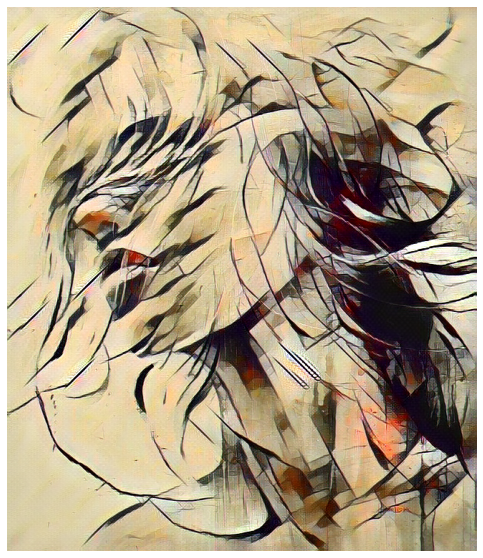

In [47]:
fig = plt.figure(figsize=(20, 10))
plt.axis('off')
plt.imshow(output_fast)